# Model 1: SPAM Classifier 

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter
import re

In [2]:
data1 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube01-Psy.csv')
data2 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube02-KatyPerry.csv')
data3 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube03-LMFAO.csv')
data4 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube04-Eminem.csv')
data5 = pd.read_csv('../../data/youtube_spam_collection_dataset/Youtube05-Shakira.csv')
data = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)
data = data[['CONTENT', 'CLASS']]

In [3]:
data.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [4]:
len(data)

1956

In [5]:
data.isna().sum()

CONTENT    0
CLASS      0
dtype: int64

In [6]:
data['CLASS'].value_counts()

CLASS
1    1005
0     951
Name: count, dtype: int64

## Data Visualization

C:\Users\davyd\AppData\Local\Temp\ipykernel_6128\2495039947.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="CLASS", data=data, palette="coolwarm")


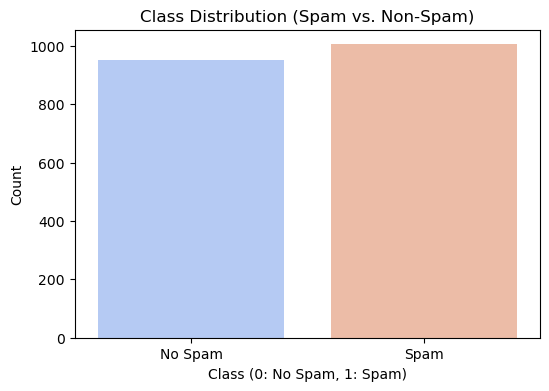

In [7]:
# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="CLASS", data=data, palette="coolwarm")
plt.title("Class Distribution (Spam vs. Non-Spam)")
plt.xlabel("Class (0: No Spam, 1: Spam)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['No Spam', 'Spam'])
plt.show()

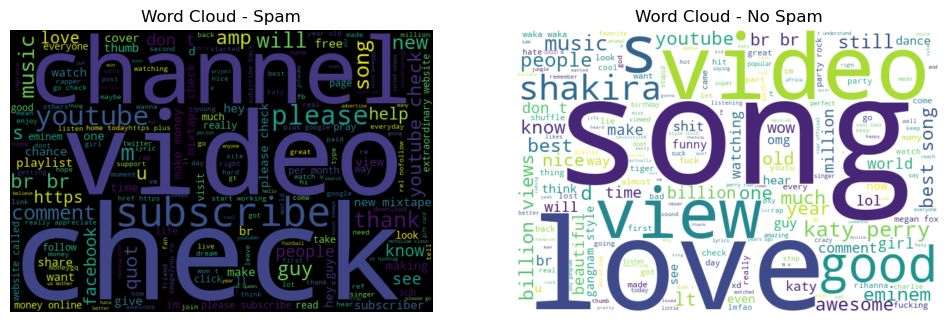

In [8]:
# 2. Word Clouds for Spam and Non-Spam
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    return text

spam_text = " ".join(data[data["CLASS"] == 1]["CONTENT"].apply(preprocess_text))
no_spam_text = " ".join(data[data["CLASS"] == 0]["CONTENT"].apply(preprocess_text))

wordcloud_spam = WordCloud(width=600, height=400, background_color="black").generate(spam_text)
wordcloud_no_spam = WordCloud(width=600, height=400, background_color="white").generate(no_spam_text)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Spam")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_no_spam, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - No Spam")

plt.show()


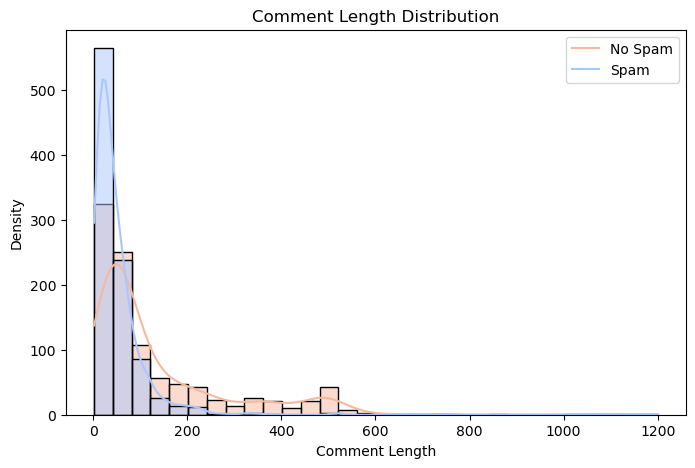

In [9]:
# 3. Comment Length Distribution
data["COMMENT_LENGTH"] = data["CONTENT"].apply(lambda x: len(str(x)))

plt.figure(figsize=(8, 5))
sns.histplot(data, x="COMMENT_LENGTH", hue="CLASS", bins=30, kde=True, palette="coolwarm")
plt.title("Comment Length Distribution")
plt.xlabel("Comment Length")
plt.ylabel("Density")
plt.legend(["No Spam", "Spam"])
plt.show()

We can notice that the sentences with spam is much shorter than the sentences with no spam. 

C:\Users\davyd\AppData\Local\Temp\ipykernel_6128\2020103782.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=spam_df["Word"], x=spam_df["Count"], palette="Reds_r")
C:\Users\davyd\AppData\Local\Temp\ipykernel_6128\2020103782.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=no_spam_df["Word"], x=no_spam_df["Count"], palette="Blues_r")


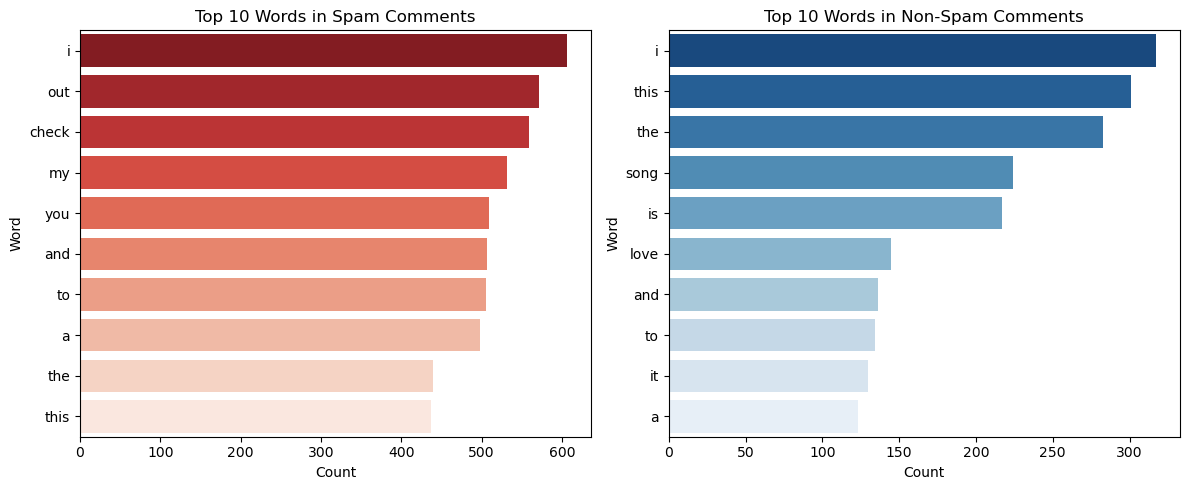

In [10]:
# 4. Most Common Words in Spam and Non-Spam
def get_most_common_words(text, num_words=10):
    words = text.split()
    return Counter(words).most_common(num_words)

spam_words = get_most_common_words(spam_text)
no_spam_words = get_most_common_words(no_spam_text)

spam_df = pd.DataFrame(spam_words, columns=["Word", "Count"])
no_spam_df = pd.DataFrame(no_spam_words, columns=["Word", "Count"])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(y=spam_df["Word"], x=spam_df["Count"], palette="Reds_r")
plt.title("Top 10 Words in Spam Comments")

plt.subplot(1, 2, 2)
sns.barplot(y=no_spam_df["Word"], x=no_spam_df["Count"], palette="Blues_r")
plt.title("Top 10 Words in Non-Spam Comments")

plt.tight_layout()
plt.show()

## Build Naive Bayes model

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data["CONTENT"])
y = data["CLASS"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
nb_model = MultinomialNB()
param_grid = {
    "alpha": [0.1, 0.5, 1.0, 2.0, 5.0] 
}
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_nb_model = grid_search.best_estimator_

## Evaluate the model

In [15]:
y_pred = best_nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9260


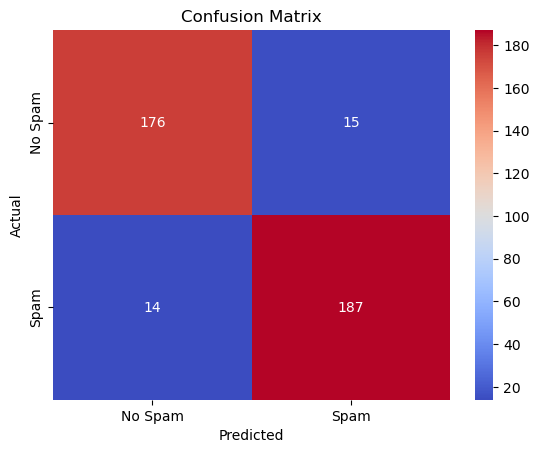

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Spam", "Spam"], yticklabels=["No Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       191
           1       0.93      0.93      0.93       201

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



Model shows good performance with 92% accuracy. But we can find some false positives and false negatives predictions. It is to important to improve recall metric, because we don't want to classify a spam sentence as no spam. So find some ways to improve recall metric is important.